In [1]:
import pandas as pd
from rapidfuzz import process, fuzz
from tqdm import tqdm
from joblib import Parallel, delayed

# Cargar datasets
df_datasetF = pd.read_csv("Nombres_Limpios_Final.csv")
df_inventor = pd.read_csv("listaNombres.csv")

Se trabajaron los nombres de las patentes y los del SNII a manera de lista para un rápido análisis. Ya que son `57,186` nombres contra `11,890` y comparar todos los nombres serian en total `679,941,540`.

In [2]:
# convertimos todas las letras en mayusculas en el dt_inventor
df_inventor['NOMBRE_INVENTOR'] = df_inventor['NOMBRE_INVENTOR'].str.upper()

# Convertir la columna NOMBRE DEL INVESTIGADOR a una lista para búsquedas más rápidas
investigadores_list = df_datasetF["NOMBRE DEL INVESTIGADOR"].tolist()

# convertimos la columna 'NOMBRE_INVENTOR' a una lista para búsquedas más rápidas
inventores_list = df_inventor["NOMBRE_INVENTOR"].tolist()

In [3]:
# Definir el umbral para considerar que dos nombres son similares
umbral = 90

In [4]:
def comparar_con_extract(inventores_list, investigadores_list):
    matches = process.extract(
        inventores_list,
        investigadores_list,
        scorer=fuzz.token_set_ratio,
        score_cutoff=umbral
    )
    # matches: lista de tuplas (nombre_investigador, ratio, index)
    return [{
        "NOMBRE DEL INVESTIGADOR": inventores_list,
        "NOMBRE_INVENTOR": match[0],
        "Ratio": match[1]
    } for match in matches]

# Procesar en paralelo cada registro de inventores usando la función extract
resultados = Parallel(n_jobs=-1)(
    delayed(comparar_con_extract)(inventores_list, investigadores_list)
    for inventores_list in tqdm(inventores_list, total=len(inventores_list), desc="Procesando inventores")
)

# Aplanar la lista de listas de resultados
resultados = [item for sublista in resultados for item in sublista]

# Convertir la lista a DataFrame y guardar los resultados
df_resultados = pd.DataFrame(resultados)

Procesando inventores: 100%|██████████| 11890/11890 [14:32<00:00, 13.62it/s]


En esta tabla vemos cuantas veces se repite un nombre para algún dato de la lista de las patentes.

In [5]:
table = df_resultados['NOMBRE DEL INVESTIGADOR'].value_counts().reset_index()
table

,NOMBRE DEL INVESTIGADOR,count
0,"LOPEZ,CARLOS A",5
1,"CRUZ,JUAN",5
2,"RODRIGUEZ,OSCAR",5
3,"E HERNANDEZ,PEDRO",5
4,"ANGEL HERNANDEZ,MIGUEL",5
...,...,...
1619,"LOPEZ CERVANTES,JAIME",1
1620,"M QUINTANA,JUAN",1
1621,"A VEGA,JUAN MANUEL",1
1622,"RAFAEL HERRERA ESTRELLA,LUIS",1


Aca es solamente para ver datos únicos y darme una idea de cuantos datos se podrían esperar en un caso optimo donde si se encontraron datos que coinciden con su nombres.

In [6]:
table1 = df_resultados['NOMBRE DEL INVESTIGADOR'].describe()
table1

count               2955
unique              1624
top       LOPEZ,CARLOS A
freq                   5
Name: NOMBRE DEL INVESTIGADOR, dtype: object

Eliminamos datos conforme a esta reglas en el dataframe 'df_resultados'
- Si el nombre en 'NOMBRE DEL INVESTIGADOR' , el primer apellido con el que empieza, no es igual al del la columna 'NOMBRE_INVENTOR', se elimina. Ejemplo
    - MARTINEZ,ALFREDO -> MARTINEZ
    - RUIZ MARTINEZ,ALFREDO -> RUIZ

No son iguales por lo que se eliminan estos registros

- Si el nombre en 'NOMBRE DEL INVESTIGADOR', el primer nombre con el que empieza, no es igual al de la columna 'NOMBRE_INVENTOR', se elimina. Ejemplo
    - RODRIGUEZ HERNANDEZ,ANDREA -> ANDREA
    - RODRIGUEZ HERNANDEZ,ANNIA -> ANNIA

In [7]:
df_resultados1 = df_resultados[
    (df_resultados['NOMBRE DEL INVESTIGADOR'].str.split().str[0] == df_resultados['NOMBRE_INVENTOR'].str.split().str[0]) &
    (df_resultados['NOMBRE DEL INVESTIGADOR'].str.split(',').str[1] == df_resultados['NOMBRE_INVENTOR'].str.split(',').str[1])
]

In [8]:
table3 = df_resultados1['NOMBRE DEL INVESTIGADOR'].value_counts().reset_index()
table3

,NOMBRE DEL INVESTIGADOR,count
0,"HERNANDEZ MAYA,ROBERTO CARLOS",2
1,"SANCHEZ VALENTE,JAIME",2
2,"FLORES SANDOVAL,CESAR ANDRES",2
3,"POSSANI POSTAY,LOURIVAL DOMINGOS",2
4,"LOPEZ SERRANO RAMOS,FRANCISCO",2
...,...,...
606,"AGUILAR ARMENDARIZ,RAMON ALBERTO",1
607,"SACRISTAN ROCK,EMILIO",1
608,"ALONSO VILATELA,MARIA ELISA",1
609,"VILLARREAL TREVINO,JUAN ANTONIO",1


Vemos que sigue habiendo datos duplicados, por lo que vamos a eliminar los duplicados solamente en la columna 'NOMBRE DEL INVESTIGADORR'

Ya que por la regla, se puede observar que son datos duplicados. 

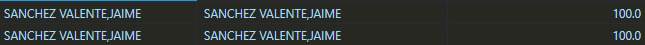

Aunque hay casos como el siguiente:

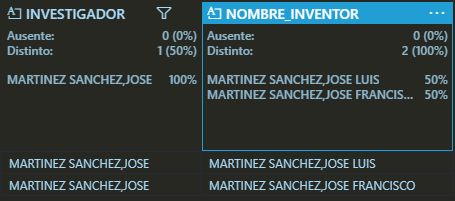

In [9]:
# Eliminamos duplicados
df_resultados1 = df_resultados1.drop_duplicates(subset=["NOMBRE DEL INVESTIGADOR"])

In [10]:
table4 = df_resultados1['NOMBRE DEL INVESTIGADOR'].value_counts().reset_index()
table4

,NOMBRE DEL INVESTIGADOR,count
0,"LIU,HONGBO",1
1,"VAZQUEZ GUEVARA,MIGUEL ANGEL",1
2,"DOMINGUEZ ESQUIVEL,JOSE MANUEL",1
3,"IBARRA GAYTAN,PABLO JESUS",1
4,"SANCHEZ LLAMAZARES,JOSE LUIS",1
...,...,...
606,"VEGA PAZ,ARACELI",1
607,"MARIN CRUZ,JESUS",1
608,"REYES VIDAL,MARIA YOLANDA",1
609,"ABURTO ANELL,JORGE ARTURO",1


Con esto nos quedamos solamente con `611` datos, contra los `972` que teníamos anteriormente, esto se debe a que se unifico las dos base de datos de patentes.

se hizo una mejora en la pre limpieza de los nombres y tenemos mas datos que son 100 de ratio que al compararlo de manera manual se puede corroborar que si coinciden los nombres. 

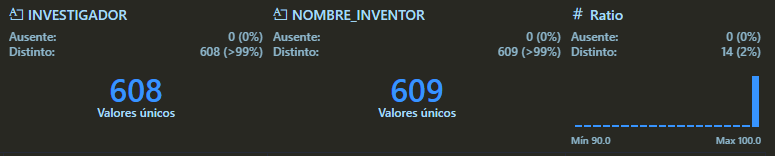




In [11]:
df_resultados.to_csv("Pre Coincidencias.csv", index=False)
df_resultados1.to_csv("Coincidencias.csv", index=False)

No se bajo el umbral a `76` como la vez pasada, por que hay mas nombres que no coinciden con el segundo apellido.

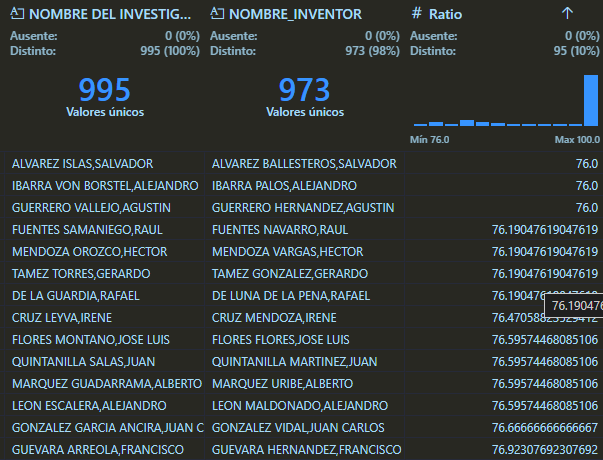